In [1]:
import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
import matplotlib.pyplot as plt
from xgbo import XgboRegressor
import os
from scipy.stats import norm
import matplotlib.mlab as mlab
import iminuit
import probfit
import probfit.pdf

In [2]:
def load_data(file_name, entrystop, isEE=False):

    root_file = uproot.open(file_name)

    # The branches we need for the regression
    branches_EB = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5',
            'iPhiMod2', 'iEtaMod20', 'iPhiMod20', 'genEnergy']

    branches_EE = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi',
            'genEnergy', 'iXSeed', 'iYSeed', 'preshowerEnergy']

    if isEE:
        branches = branches_EE + ["pt", "eta"]
    else:
        branches = branches_EB + ["pt", "eta"]

    if "Electron" in file_name:
        df = root_file['een_analyzer/ElectronTree'].pandas.df(branches, entrystop=entrystop).dropna()
    if "Photon" in file_name:
        df = root_file['een_analyzer/PhotonTree'].pandas.df(branches, entrystop=entrystop).dropna()
    print("Entries in ntuple:")
    print(len(df))
    print(df.shape)


    df.eval("clusertRawEnergyOverE5x5 = clusterRawEnergy/full5x5_e5x5", inplace=True)
    df.eval("w3x3OverE5x5             = full5x5_e3x3/full5x5_e5x5", inplace=True)
    df.eval("eMaxOverE5x5             = full5x5_eMax/full5x5_e5x5", inplace=True)
    df.eval("e2ndOverE5x5             = full5x5_e2nd/full5x5_e5x5", inplace=True)
    df.eval("eTopOverE5x5             = full5x5_eTop/full5x5_e5x5", inplace=True)
    df.eval("eBottomOverE5x5          = full5x5_eBottom/full5x5_e5x5", inplace=True)
    df.eval("eLeftOverE5x5            = full5x5_eLeft/full5x5_e5x5", inplace=True)
    df.eval("eRightOverE5x5           = full5x5_eRight/full5x5_e5x5", inplace=True)
    df.eval("e2x5MaxOverE5x5          = full5x5_e2x5Max/full5x5_e5x5", inplace=True)
    df.eval("e2x5TopOverE5x5          = full5x5_e2x5Top/full5x5_e5x5", inplace=True)
    df.eval("e2x5BottomOverE5x5       = full5x5_e2x5Bottom/full5x5_e5x5", inplace=True)
    df.eval("e2x5LeftOverE5x5         = full5x5_e2x5Left/full5x5_e5x5", inplace=True)
    df.eval("e2x5RightOverE5x5        = full5x5_e2x5Right/full5x5_e5x5", inplace=True)

    if isEE:
        df.eval("preshowerEnergyOverrawEnergy = preshowerEnergy/rawEnergy", inplace=True)

    # The target
    if isEE:
        df.eval("target = ( rawEnergy + preshowerEnergy )/genEnergy", inplace=True)
    else:
        df.eval("target = rawEnergy/genEnergy", inplace=True)

    return df


In [3]:
# The features
features_EB = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5', 'iPhiMod2',
        'iEtaMod20', 'iPhiMod20','pt','eta','target']

# EE
features_EE = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iXSeed', 'iYSeed', 'preshowerEnergyOverrawEnergy','pt','eta','target']


file_name = "/scratch/micheli/Electron/perfectIC-lowpt-EB-training.root"


isEE = '-EE-' in file_name

if isEE:
    features = features_EE
else:
    features = features_EB
DF= load_data(file_name, entrystop=1500000,isEE=isEE)



Entries in ntuple:
3428975
(3428975, 30)


In [4]:
DF=DF.query('pt>20')

Entries in ntuple:
3428975
(3428975, 30)


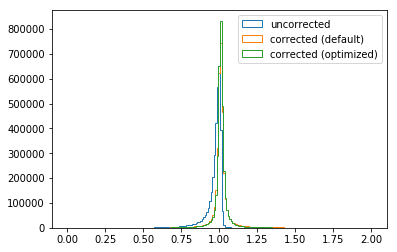

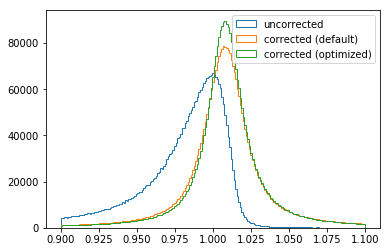

In [5]:
df_test  = load_data(file_name, isEE=isEE, entrystop=1500000)
X_test  = df_test[features_EB]
y_test  = df_test["target"]
xgtest  = xgb.DMatrix(X_test , label=y_test)
out_dir='/work/okiss/SemesterProject_2/xgbo/Energy_Regression_test/'
xgbo_default = xgb.Booster({'nthread':4}) #init model
#xgbo_default.load_model("Photon_perfectIC-highpt-EB/model_default/model.bin") # load data
xgbo_default.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_default/model.bin")
xgbo_bo = xgb.Booster({'nthread':4}) #init model
#xgbo_bo.load_model("Photon_perfectIC-highpt-EB/model_optimized/model.bin") # load data
xgbo_bo.load_model(out_dir+"Electron_perfectIC-lowpt-EB_test20190124/model_optimized/model.bin") # load data

preds_default = xgbo_default.predict(xgtest)
preds_bo      = xgbo_bo.predict(xgtest)

# preds = 1.

# Etrue / Eraw after applying corrections
z_default = preds_default / (df_test['genEnergy']/df_test['rawEnergy'])
z_bo      = preds_bo / (df_test['genEnergy']/df_test['rawEnergy'])

bins = np.linspace(0.0, 2.0, 200)
bins_zoom = np.linspace(0.9, 1.1, 200)

plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins, histtype='step', label="uncorrected")
plt.hist(z_default, bins=bins, histtype='step', label='corrected (default)')
plt.hist(z_bo, bins=bins, histtype='step', label='corrected (optimized)')
plt.legend()
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison'+'.png'))
plt.show()


plt.figure()
plt.hist(df_test['rawEnergy']/df_test['genEnergy'], bins=bins_zoom, histtype='step', label="uncorrected")
plt.hist(z_default, bins=bins_zoom, histtype='step', label='corrected (default)')
plt.hist(z_bo, bins=bins_zoom, histtype='step', label='corrected (optimized)')
plt.legend()
plt.savefig(os.path.join(out_dir+'plot','energy_comparaison_zoom'+'.png'))
plt.show()

In [6]:
data=pd.DataFrame()
data['eta']=df_test['eta']
data['pt']=df_test['pt']
data['target']=df_test['target']
data['z_default']=z_default
data['z_bo']=z_bo
print(data.columns)

Index([u'eta', u'pt', u'target', u'z_default', u'z_bo'], dtype='object')


In [7]:
n=29
mean_pt_un=np.zeros((n))
mean_err_pt_un=np.zeros((n))
sigma_pt_un=np.zeros((n))
sigma_err_pt_un=np.zeros((n))

pt=np.zeros((n))
feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
nbins=200


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:75: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:75: SmallIntegralWarning: (0.8855526494849895, 1.3060900508286117, 0.99088477087933, 10.138604117596927, 1.0036936031743422, 0.00823524934466402)


FCN = 420.786882549 
 TOTAL NCALL = 518 
 NCALLS = 507 
 
 
 EDM = 7.62041263042 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.596937,0.139226,,,,,No
1,alpha2,2.77206,0.223465,,,,,No
2,n,84.7348,661.265,,,0,1000,No
3,n2,3.44985,2.30659,,,0,1000,No
4,mean,1.00588,0.000275278,,,0.9,1.1,No
5,sigma,0.00783398,0.000124052,,,0,1,No


FCN = 5357.25273766 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.622209,nan,,,,,No
1,alpha2,2.77206,nan,,,,,No
2,n,84.7348,nan,,,0,1000,No
3,n2,3.44985,nan,,,0,1000,No
4,mean,1.00807,nan,,,0.9,1.1,No
5,sigma,0.1,1,,,0,1,Yes


FCN = 1076.62639347 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.622209,nan,,,,,No
1,alpha2,2.77206,nan,,,,,No
2,n,84.7348,1,,,0,1000,Yes
3,n2,3.44985,1,,,0,1000,Yes
4,mean,1.00807,nan,,,0.9,1.1,No
5,sigma,0.00557473,nan,,,0,1,No


FCN = 420.415244234 
 TOTAL NCALL = 395 
 NCALLS = 395 
 
 
 EDM = 2.1314666847e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.652875,0.0693102,,,,,No
1,alpha2,2.82451,0.285851,,,,,No
2,n,18.8705,16.4655,,,0,1000,No
3,n2,3.28992,2.92384,,,0,1000,No
4,mean,1.00557,0.000425709,,,0.9,1.1,No
5,sigma,0.00802429,0.000285553,,,0,1,No


FCN = 420.415241996 
 TOTAL NCALL = 92 
 NCALLS = 92 
 
 
 EDM = 2.06424868289e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.652855,0.0717139,,,,,No
1,alpha2,2.82451,0.289355,,,,,No
2,n,18.8765,17.1907,,,0,1000,No
3,n2,3.29007,2.93029,,,0,1000,No
4,mean,1.00557,0.000436106,,,0.9,1.1,No
5,sigma,0.00802442,0.000291859,,,0,1,No


300<pt<310
0


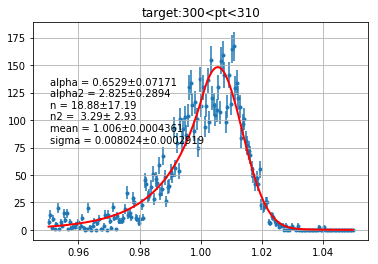

In [8]:
i=0
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.95, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(5):
        #first step
       
    if j==0: 
            pars_dcb = dict(mean  = 1.003, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma =False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = False,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 5,
                        fix_n2  = False)
       
    elif j==1:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = 0.1,
                        fix_sigma = True,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
    
    elif j==2:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = True
                        )
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
    
    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 3223.31874701 
 TOTAL NCALL = 164 
 NCALLS = 164 
 
 
 EDM = 2.87773955413e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,1.03941,0.00651865,,,0,100,No
1,alpha2,3.12834,0.918865,,,,,No
2,n,100,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997483,4.82312e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1404.71246717 
 TOTAL NCALL = 365 
 NCALLS = 354 
 
 
 EDM = 2.27081003707 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.575261,0.00644903,,,0,100,No
1,alpha2,8.8589,0.213442,,,,,No
2,n,122.512,14.9701,,,0,1000,No
3,n2,132.98,285.724,,,0,1000,No
4,mean,1.00127,7.8363e-05,,,0.9,1.1,No
5,sigma,0.00815007,5.47735e-05,,,0,1,No


FCN = 1404.71246717 
 TOTAL NCALL = 50 
 NCALLS = 39 
 
 
 EDM = 7.73130758042 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.575261,1,,,0,100,Yes
1,alpha2,8.8589,1,,,,,Yes
2,n,122.512,0,,,0,1000,No
3,n2,132.98,0,,,0,1000,No
4,mean,1.00127,1,,,0.9,1.1,Yes
5,sigma,0.00815007,0,,,0,1,No


FCN = 1404.71246717 
 TOTAL NCALL = 80 
 NCALLS = 69 
 
 
 EDM = 7.77131257907 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.575261,0,,,0,100,No
1,alpha2,8.8589,0,,,,,No
2,n,122.512,0,,,0,1000,No
3,n2,132.98,0,,,0,1000,No
4,mean,1.00127,0,,,0.9,1.1,No
5,sigma,0.00815007,0,,,0,1,No


FCN = 1404.71246717 
 TOTAL NCALL = 80 
 NCALLS = 69 
 
 
 EDM = 7.77131257907 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.575261,0,,,0,100,No
1,alpha2,8.8589,0,,,,,No
2,n,122.512,0,,,0,1000,No
3,n2,132.98,0,,,0,1000,No
4,mean,1.00127,0,,,0.9,1.1,No
5,sigma,0.00815007,0,,,0,1,No


290<pt<300
1


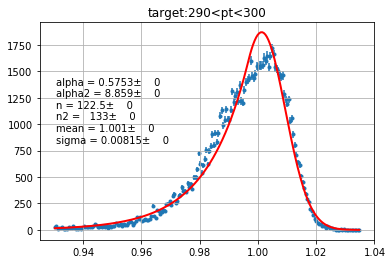

In [9]:
i=1
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.93, 1.035]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(5):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0015, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 100,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
  
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 2226.4400704 
 TOTAL NCALL = 182 
 NCALLS = 182 
 
 
 EDM = 7.63415113269e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.735863,0.00401377,,,0,100,No
1,alpha2,3.39965,1.60267,,,,,No
2,n,100,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997703,4.71747e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1108.51774296 
 TOTAL NCALL = 186 
 NCALLS = 186 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.46966,nan,,,0,100,No
1,alpha2,34.331,nan,,,,,No
2,n,49.5231,nan,,,0,1000,No
3,n2,121.662,nan,,,0,1000,No
4,mean,1.00119,nan,,,0.9,1.1,No
5,sigma,0.00794068,nan,,,0,1,No


FCN = 1077.99240844 
 TOTAL NCALL = 71 
 NCALLS = 60 
 
 
 EDM = 0.580067701791 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.46966,1,,,0,100,Yes
1,alpha2,34.331,1,,,,,Yes
2,n,119.726,0,,,0,1000,No
3,n2,121.662,0,,,0,1000,No
4,mean,1.00119,1,,,0.9,1.1,Yes
5,sigma,0.00800885,0,,,0,1,No


FCN = 1077.99240844 
 TOTAL NCALL = 80 
 NCALLS = 69 
 
 
 EDM = 7.22275833022 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.46966,0,,,0,100,No
1,alpha2,34.331,0,,,,,No
2,n,119.726,0,,,0,1000,No
3,n2,121.662,0,,,0,1000,No
4,mean,1.00119,0,,,0.9,1.1,No
5,sigma,0.00800885,0,,,0,1,No


FCN = 1077.99240844 
 TOTAL NCALL = 80 
 NCALLS = 69 
 
 
 EDM = 7.22275833022 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.46966,0,,,0,100,No
1,alpha2,34.331,0,,,,,No
2,n,119.726,0,,,0,1000,No
3,n2,121.662,0,,,0,1000,No
4,mean,1.00119,0,,,0.9,1.1,No
5,sigma,0.00800885,0,,,0,1,No


280<pt<290
2


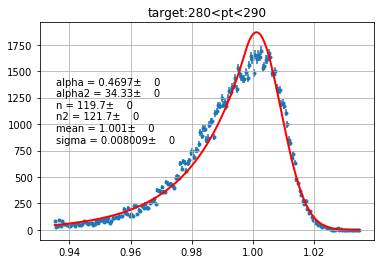

In [10]:
i=2
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.935, 1.035]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(5):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.002, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 100,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
  
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 2137.60055557 
 TOTAL NCALL = 174 
 NCALLS = 174 
 
 
 EDM = 9.62459982896e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.763591,0.00401537,,,0,100,No
1,alpha2,3.39937,1.33521,,,,,No
2,n,10,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.99763,4.70554e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1134.67866624 
 TOTAL NCALL = 127 
 NCALLS = 127 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.498385,nan,,,0,100,No
1,alpha2,16.6599,nan,,,,,No
2,n,12.5567,nan,,,0,1000,No
3,n2,154.651,nan,,,0,1000,No
4,mean,1.00084,nan,,,0.9,1.1,No
5,sigma,0.0082336,nan,,,0,1,No


FCN = 1067.26881906 
 TOTAL NCALL = 65 
 NCALLS = 65 
 
 
 EDM = 2.96530718353e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.498385,1,,,0,100,Yes
1,alpha2,16.6599,1,,,,,Yes
2,n,27.6084,2.78676,,,0,1000,No
3,n2,154.651,304.252,,,0,1000,No
4,mean,1.00084,1,,,0.9,1.1,Yes
5,sigma,0.00835336,2.80785e-05,,,0,1,No


FCN = 991.436421738 
 TOTAL NCALL = 126 
 NCALLS = 126 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.469281,nan,,,0,100,No
1,alpha2,16.6599,nan,,,,,No
2,n,91.4096,nan,,,0,1000,No
3,n2,154.651,nan,,,0,1000,No
4,mean,1.00092,nan,,,0.9,1.1,No
5,sigma,0.00826566,nan,,,0,1,No


270<pt<280
3


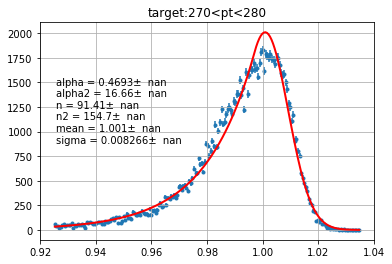

In [11]:
i=3
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.925, 1.035]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
  
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 2028.70719644 
 TOTAL NCALL = 156 
 NCALLS = 156 
 
 
 EDM = 1.84974761639e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.753894,0.00415369,,,0,100,No
1,alpha2,3.43923,0.28507,,,,,No
2,n,10,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997466,4.78449e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 935.039551964 
 TOTAL NCALL = 366 
 NCALLS = 355 
 
 
 EDM = 588578.228074 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.45769,0.000778099,,,0,100,No
1,alpha2,3.20349,0.215569,,,,,No
2,n,87.793,2.58205,,,0,1000,No
3,n2,6.65548,991.126,,,0,1000,No
4,mean,1.00078,3.84894e-05,,,0.9,1.1,No
5,sigma,0.00824738,6.91695e-05,,,0,1,No


FCN = 928.486223337 
 TOTAL NCALL = 70 
 NCALLS = 59 
 
 
 EDM = 7.05792971677 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.45769,1,,,0,100,Yes
1,alpha2,3.20349,1,,,,,Yes
2,n,87.793,12.4669,,,0,1000,No
3,n2,2.52315,0.566968,,,0,1000,No
4,mean,1.00078,1,,,0.9,1.1,Yes
5,sigma,0.00824738,2.46315e-05,,,0,1,No


FCN = 928.486223337 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 12.8555242625 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.45769,0.00479813,,,0,100,No
1,alpha2,3.20349,0.155099,,,,,No
2,n,87.793,13.3761,,,0,1000,No
3,n2,2.52315,1.40527,,,0,1000,No
4,mean,1.00078,8.3751e-05,,,0.9,1.1,No
5,sigma,0.00824738,5.59731e-05,,,0,1,No


260<pt<270
4


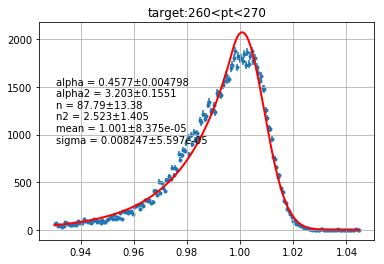

In [12]:
i=4
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.93, 1.045]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0005, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
  
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1751.51475308 
 TOTAL NCALL = 148 
 NCALLS = 148 
 
 
 EDM = 3.58402366333e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.698045,0.00457998,,,0,100,No
1,alpha2,2.48726,0.479051,,,,,No
2,n,10,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997634,5.18376e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1751.51475307 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 947.814976412 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.698045,0.0124622,,,0,100,No
1,alpha2,2.48726,0.481384,,,,,No
2,n,10,0.897253,,,0,1000,No
3,n2,151.948,880.67,,,0,1000,No
4,mean,0.997634,0.000106722,,,0.9,1.1,No
5,sigma,0.011,9.5872e-05,,,0,1,No


FCN = 1751.51475306 
 TOTAL NCALL = 70 
 NCALLS = 59 
 
 
 EDM = 152.128945483 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.698045,1,,,0,100,Yes
1,alpha2,2.48726,1,,,,,Yes
2,n,10,0.600008,,,0,1000,No
3,n2,165.181,820.168,,,0,1000,No
4,mean,0.997634,1,,,0.9,1.1,Yes
5,sigma,0.011,4.37031e-05,,,0,1,No


FCN = 1172.12389306 
 TOTAL NCALL = 119 
 NCALLS = 108 
 
 
 EDM = 11850.9672423 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.499701,0.0123045,,,0,100,No
1,alpha2,2.48767,0.479399,,,,,No
2,n,19.0599,1.28919,,,0,1000,No
3,n2,108.62,854.873,,,0,1000,No
4,mean,0.999422,0.000123377,,,0.9,1.1,No
5,sigma,0.00923887,0.000106165,,,0,1,No


250<pt<260
5


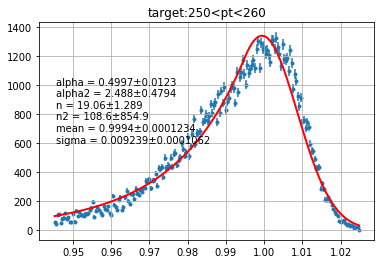

In [13]:
i=5
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0005, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1723.89400028 
 TOTAL NCALL = 152 
 NCALLS = 152 
 
 
 EDM = 1.39205797197e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.673862,0.00444371,,,0,100,No
1,alpha2,2.49686,0.485476,,,,,No
2,n,10,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997517,5.2257e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1197.84771397 
 TOTAL NCALL = 117 
 NCALLS = 106 
 
 
 EDM = 103771765.459 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.477457,0.0119877,,,0,100,No
1,alpha2,2.4978,0.520913,,,,,No
2,n,18.8349,1.19634,,,0,1000,No
3,n2,4.84002,736.229,,,0,1000,No
4,mean,0.999439,0.000131084,,,0.9,1.1,No
5,sigma,0.00917965,0.000109511,,,0,1,No


FCN = 1085.72048898 
 TOTAL NCALL = 108 
 NCALLS = 97 
 
 
 EDM = 4.76417391672 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.477457,1,,,0,100,Yes
1,alpha2,2.4978,1,,,,,Yes
2,n,96.107,19.1316,,,0,1000,No
3,n2,61.9057,99.8086,,,0,1000,No
4,mean,0.999439,1,,,0.9,1.1,Yes
5,sigma,0.00902938,2.95149e-05,,,0,1,No


FCN = 1085.72048898 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 87.8933081705 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.477457,0.00596284,,,0,100,No
1,alpha2,2.4978,0.0783815,,,,,No
2,n,96.107,20.1106,,,0,1000,No
3,n2,61.9057,103.412,,,0,1000,No
4,mean,0.999439,9.73534e-05,,,0.9,1.1,No
5,sigma,0.00902938,6.93411e-05,,,0,1,No


240<pt<250
6


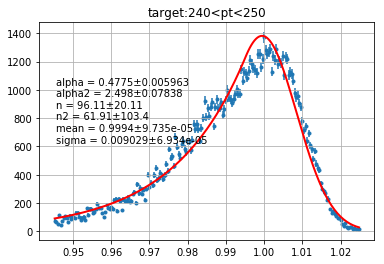

In [14]:
i=6
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0005, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1659.19326691 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = 1.13675369087e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.664753,0.00440984,,,0,100,No
1,alpha2,2.49993,0.528877,,,,,No
2,n,10,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997486,5.2581e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1071.44037106 
 TOTAL NCALL = 120 
 NCALLS = 109 
 
 
 EDM = 44670.2444969 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.445182,0.0107269,,,0,100,No
1,alpha2,2.50127,0.52892,,,,,No
2,n,20.2339,1.25582,,,0,1000,No
3,n2,96.6138,940.38,,,0,1000,No
4,mean,0.999712,0.000123189,,,0.9,1.1,No
5,sigma,0.00884515,0.000102691,,,0,1,No


FCN = 1008.53630431 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.445182,1,,,0,100,Yes
1,alpha2,2.50127,1,,,,,Yes
2,n,32.758,nan,,,0,1000,No
3,n2,167.484,nan,,,0,1000,No
4,mean,0.999712,1,,,0.9,1.1,Yes
5,sigma,0.0086768,nan,,,0,1,No


FCN = 875.778936802 
 TOTAL NCALL = 161 
 NCALLS = 150 
 
 
 EDM = 1.61423377721 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.401412,0.00475288,,,0,100,No
1,alpha2,2.98368,0.102287,,,,,No
2,n,122.559,17.6831,,,0,1000,No
3,n2,103.145,530.957,,,0,1000,No
4,mean,1.00087,9.62563e-05,,,0.9,1.1,No
5,sigma,0.00809915,6.4712e-05,,,0,1,No


230<pt<240
7


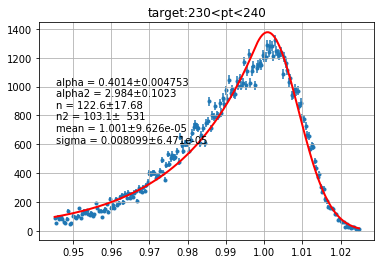

In [15]:
i=7
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0005, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1496.79310326 
 TOTAL NCALL = 148 
 NCALLS = 148 
 
 
 EDM = 2.10287278268e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.626162,0.00421345,,,0,100,No
1,alpha2,2.51475,0.506275,,,,,No
2,n,10,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997316,5.34303e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1117.43334517 
 TOTAL NCALL = 117 
 NCALLS = 106 
 
 
 EDM = 1.01113295082e+11 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.432262,0.0177344,,,0,100,No
1,alpha2,2.51588,0.509413,,,,,No
2,n,19.326,1.46186,,,0,1000,No
3,n2,0.000975783,17.8477,,,0,1000,No
4,mean,0.9995,0.00022195,,,0.9,1.1,No
5,sigma,0.00897682,0.000189965,,,0,1,No


FCN = 942.111820284 
 TOTAL NCALL = 113 
 NCALLS = 102 
 
 
 EDM = 5.17366892937 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.432262,1,,,0,100,Yes
1,alpha2,2.51588,1,,,,,Yes
2,n,116.088,22.8895,,,0,1000,No
3,n2,11.178,8.65643,,,0,1000,No
4,mean,0.9995,1,,,0.9,1.1,Yes
5,sigma,0.00893246,2.98463e-05,,,0,1,No


FCN = 942.111820284 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 37.9292072894 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.432262,0.00543803,,,0,100,No
1,alpha2,2.51588,0.0867294,,,,,No
2,n,116.088,23.5036,,,0,1000,No
3,n2,11.178,10.3455,,,0,1000,No
4,mean,0.9995,0.000101412,,,0.9,1.1,No
5,sigma,0.00893246,7.03085e-05,,,0,1,No


220<pt<230
8


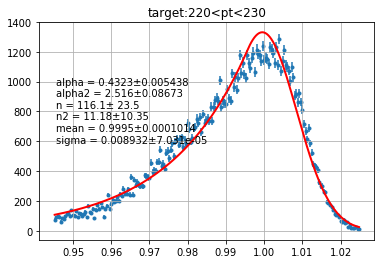

In [16]:
i=8
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0005, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 10,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 2141.442686 
 TOTAL NCALL = 145 
 NCALLS = 145 
 
 
 EDM = 1.22694532276e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.761293,0.00552429,,,0,100,No
1,alpha2,2.38416,0.569037,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.996403,5.62378e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 922.419178359 
 TOTAL NCALL = 145 
 NCALLS = 145 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.404765,nan,,,0,100,No
1,alpha2,24.3835,nan,,,,,No
2,n,20.4451,nan,,,0,1000,No
3,n2,394.876,nan,,,0,1000,No
4,mean,1.00052,nan,,,0.9,1.1,No
5,sigma,0.00841478,nan,,,0,1,No


FCN = 863.318749231 
 TOTAL NCALL = 92 
 NCALLS = 81 
 
 
 EDM = 1.2854423879 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.404765,1,,,0,100,Yes
1,alpha2,24.3835,1,,,,,Yes
2,n,121.879,0,,,0,1000,No
3,n2,394.876,0,,,0,1000,No
4,mean,1.00052,1,,,0.9,1.1,Yes
5,sigma,0.00834412,0,,,0,1,No


FCN = 863.318749231 
 TOTAL NCALL = 82 
 NCALLS = 71 
 
 
 EDM = 16.6996231015 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.404765,0,,,0,100,No
1,alpha2,24.3835,0,,,,,No
2,n,121.879,0,,,0,1000,No
3,n2,394.876,0,,,0,1000,No
4,mean,1.00052,0,,,0.9,1.1,No
5,sigma,0.00834412,0,,,0,1,No


210<pt<220
9


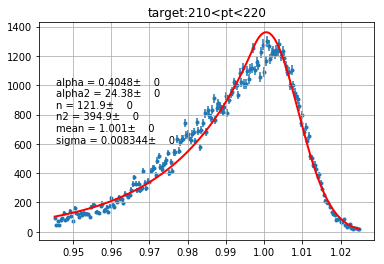

In [17]:
i=9
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

OK


FCN = 1756.56652887 
 TOTAL NCALL = 149 
 NCALLS = 149 
 
 
 EDM = 1.02759054484e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.739171,0.0053189,,,0,100,No
1,alpha2,2.53117,0.530322,,,,,No
2,n,3,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.997157,5.31542e-05,,,0.9,1.1,No
5,sigma,0.011,1,,,0,1,Yes


FCN = 1041.14003168 
 TOTAL NCALL = 126 
 NCALLS = 126 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.418957,nan,,,0,100,No
1,alpha2,14.4126,nan,,,,,No
2,n,11.6288,nan,,,0,1000,No
3,n2,173.939,nan,,,0,1000,No
4,mean,1.00036,nan,,,0.9,1.1,No
5,sigma,0.00839624,nan,,,0,1,No


FCN = 934.970978447 
 TOTAL NCALL = 94 
 NCALLS = 83 
 
 
 EDM = 0.0264740432086 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.418957,1,,,0,100,Yes
1,alpha2,14.4126,1,,,,,Yes
2,n,115.616,0,,,0,1000,No
3,n2,173.939,0,,,0,1000,No
4,mean,1.00036,1,,,0.9,1.1,Yes
5,sigma,0.00857816,0,,,0,1,No


FCN = 934.970978447 
 TOTAL NCALL = 74 
 NCALLS = 63 
 
 
 EDM = 44.5730743439 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.418957,0,,,0,100,No
1,alpha2,14.4126,0,,,,,No
2,n,115.616,0,,,0,1000,No
3,n2,173.939,0,,,0,1000,No
4,mean,1.00036,0,,,0.9,1.1,No
5,sigma,0.00857816,0,,,0,1,No


FCN = 934.970978447 
 TOTAL NCALL = 74 
 NCALLS = 63 
 
 
 EDM = 44.5730743439 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.418957,0,,,0,100,No
1,alpha2,14.4126,0,,,,,No
2,n,115.616,0,,,0,1000,No
3,n2,173.939,0,,,0,1000,No
4,mean,1.00036,0,,,0.9,1.1,No
5,sigma,0.00857816,0,,,0,1,No


220<pt<230
8


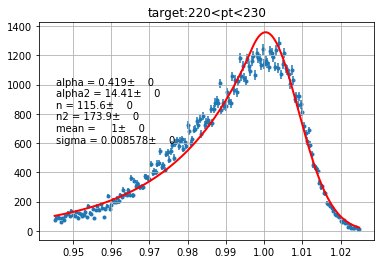

In [18]:
i=8
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(5):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.0005, 
                        fix_mean = False,
                        sigma  = 0.011,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 3,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1801.71915 
 TOTAL NCALL = 159 
 NCALLS = 159 
 
 
 EDM = 4.07232981334e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.727597,0.00536968,,,0,100,No
1,alpha2,2.41418,0.509947,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.99605,5.69572e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 832.147771274 
 TOTAL NCALL = 144 
 NCALLS = 144 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.395921,nan,,,0,100,No
1,alpha2,26.0007,nan,,,,,No
2,n,22.7554,nan,,,0,1000,No
3,n2,366.199,nan,,,0,1000,No
4,mean,0.999988,nan,,,0.9,1.1,No
5,sigma,0.00860641,nan,,,0,1,No


FCN = 777.595493363 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 0.29243840183 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.395921,1,,,0,100,Yes
1,alpha2,26.0007,1,,,,,Yes
2,n,118.673,0,,,0,1000,No
3,n2,366.199,0,,,0,1000,No
4,mean,0.999988,1,,,0.9,1.1,Yes
5,sigma,0.00857766,0,,,0,1,No


FCN = 777.595493363 
 TOTAL NCALL = 82 
 NCALLS = 71 
 
 
 EDM = 4.43607804399 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.395921,0,,,0,100,No
1,alpha2,26.0007,0,,,,,No
2,n,118.673,0,,,0,1000,No
3,n2,366.199,0,,,0,1000,No
4,mean,0.999988,0,,,0.9,1.1,No
5,sigma,0.00857766,0,,,0,1,No


200<pt<210
10


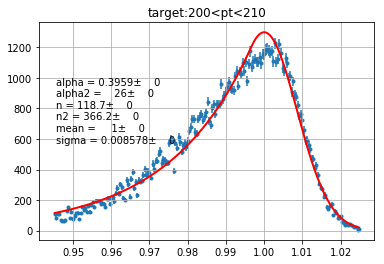

In [19]:
i=10
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.945, 1.025]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

# OK after that

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 2032.60683243 
 TOTAL NCALL = 176 
 NCALLS = 176 
 
 
 EDM = 4.73752628508e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.749935,0.00420264,,,0,100,No
1,alpha2,3.70651,1.83687,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.995523,5.28364e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 786.983262105 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.417715,nan,,,0,100,No
1,alpha2,28.3014,nan,,,,,No
2,n,17.9266,nan,,,0,1000,No
3,n2,134.136,nan,,,0,1000,No
4,mean,0.999553,nan,,,0.9,1.1,No
5,sigma,0.00871292,nan,,,0,1,No


FCN = 681.083292028 
 TOTAL NCALL = 92 
 NCALLS = 81 
 
 
 EDM = 0.613709142273 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.417715,1,,,0,100,Yes
1,alpha2,28.3014,1,,,,,Yes
2,n,112.375,0,,,0,1000,No
3,n2,134.136,0,,,0,1000,No
4,mean,0.999553,1,,,0.9,1.1,Yes
5,sigma,0.00889881,0,,,0,1,No


FCN = 681.083292028 
 TOTAL NCALL = 80 
 NCALLS = 69 
 
 
 EDM = 16.2528052465 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.417715,0,,,0,100,No
1,alpha2,28.3014,0,,,,,No
2,n,112.375,0,,,0,1000,No
3,n2,134.136,0,,,0,1000,No
4,mean,0.999553,0,,,0.9,1.1,No
5,sigma,0.00889881,0,,,0,1,No


190<pt<200
11


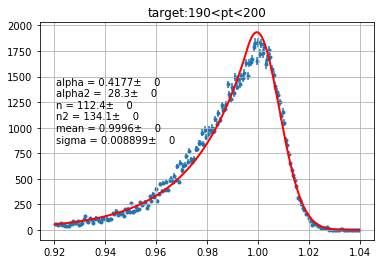

In [20]:
i=11
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.92, 1.04]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 2104.57830798 
 TOTAL NCALL = 173 
 NCALLS = 173 
 
 
 EDM = 1.65868332747e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.728296,0.00372947,,,0,100,No
1,alpha2,3.58891,0.804263,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.995242,5.37722e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 894.346382047 
 TOTAL NCALL = 267 
 NCALLS = 267 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.390577,nan,,,0,100,No
1,alpha2,4.28807,nan,,,,,No
2,n,94.2914,nan,,,0,1000,No
3,n2,167.013,nan,,,0,1000,No
4,mean,0.99937,nan,,,0.9,1.1,No
5,sigma,0.00885326,nan,,,0,1,No


FCN = 889.768321506 
 TOTAL NCALL = 86 
 NCALLS = 75 
 
 
 EDM = 7.17087272619 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.390577,1,,,0,100,Yes
1,alpha2,4.28807,1,,,,,Yes
2,n,94.2914,12.8555,,,0,1000,No
3,n2,0.00138672,0.0284006,,,0,1000,No
4,mean,0.99937,1,,,0.9,1.1,Yes
5,sigma,0.00885326,2.61733e-05,,,0,1,No


FCN = 889.768321506 
 TOTAL NCALL = 89 
 NCALLS = 78 
 
 
 EDM = 19.2786124198 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.390577,0.00389054,,,0,100,No
1,alpha2,4.28807,0.219276,,,,,No
2,n,94.2914,13.8801,,,0,1000,No
3,n2,0.00138672,0.0283187,,,0,1000,No
4,mean,0.99937,9.48749e-05,,,0.9,1.1,No
5,sigma,0.00885326,6.17018e-05,,,0,1,No


180<pt<190
12


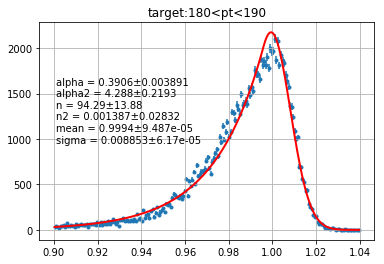

In [21]:
i=12
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.9, 1.04]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1763.04116788 
 TOTAL NCALL = 143 
 NCALLS = 143 
 
 
 EDM = 1.52446849584e-09 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.691567,0.00309107,,,0,100,No
1,alpha2,3.0582,0.121409,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.995185,5.3479e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 960.577670465 
 TOTAL NCALL = 433 
 NCALLS = 433 
 
 
 EDM = 3.37818143324e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.405114,0.00605934,,,0,100,No
1,alpha2,2.85782,0.105912,,,,,No
2,n,16.0096,1.27522,,,0,1000,No
3,n2,2.83295,0.848397,,,0,1000,No
4,mean,0.998977,0.000110254,,,0.9,1.1,No
5,sigma,0.00908692,7.26843e-05,,,0,1,No


FCN = 960.577670136 
 TOTAL NCALL = 44 
 NCALLS = 44 
 
 
 EDM = 8.36527462563e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.405114,1,,,0,100,Yes
1,alpha2,2.85782,1,,,,,Yes
2,n,16.0101,0.66289,,,0,1000,No
3,n2,2.83294,0.376759,,,0,1000,No
4,mean,0.998977,1,,,0.9,1.1,Yes
5,sigma,0.00908694,3.21863e-05,,,0,1,No


FCN = 960.577669582 
 TOTAL NCALL = 95 
 NCALLS = 95 
 
 
 EDM = 2.47065997084e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.405115,0.00605867,,,0,100,No
1,alpha2,2.85783,0.103589,,,,,No
2,n,16.0103,1.27557,,,0,1000,No
3,n2,2.83295,0.829746,,,0,1000,No
4,mean,0.998977,0.000110236,,,0.9,1.1,No
5,sigma,0.00908694,7.26523e-05,,,0,1,No


170<pt<180
13


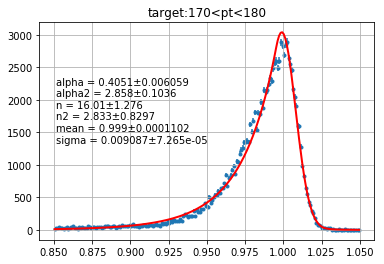

In [22]:
i=13
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1669.21213139 
 TOTAL NCALL = 154 
 NCALLS = 154 
 
 
 EDM = 1.2011970483e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.66958,0.0029773,,,0,100,No
1,alpha2,3.46091,0.263292,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.994927,5.37728e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1160.96168827 
 TOTAL NCALL = 230 
 NCALLS = 219 
 
 
 EDM = 630.058125951 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.508806,0.00840767,,,0,100,No
1,alpha2,3.81158,3.37575,,,,,No
2,n,6.38896,0.200036,,,0,1000,No
3,n2,143.25,274.483,,,0,1000,No
4,mean,0.997491,0.000129461,,,0.9,1.1,No
5,sigma,0.0099621,0.000100171,,,0,1,No


FCN = 1130.66401152 
 TOTAL NCALL = 96 
 NCALLS = 96 
 
 
 EDM = 7.25505222828e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.508806,1,,,0,100,Yes
1,alpha2,3.81158,1,,,,,Yes
2,n,7.07146,0.139762,,,0,1000,No
3,n2,0.421277,0.257156,,,0,1000,No
4,mean,0.997491,1,,,0.9,1.1,Yes
5,sigma,0.0100376,3.39004e-05,,,0,1,No


FCN = 1026.69429302 
 TOTAL NCALL = 281 
 NCALLS = 281 
 
 
 EDM = 5.2968896849e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.428527,0.00590335,,,0,100,No
1,alpha2,3.8041,0.152058,,,,,No
2,n,13.3492,0.90928,,,0,1000,No
3,n2,0.37006,0.443377,,,0,1000,No
4,mean,0.998076,0.000102762,,,0.9,1.1,No
5,sigma,0.0096115,6.54575e-05,,,0,1,No


160<pt<170
14


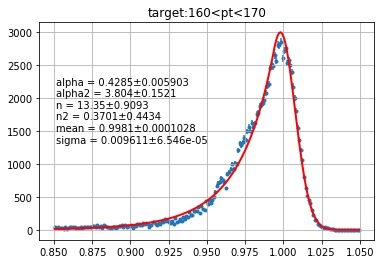

In [23]:
i=14
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1617.34353751 
 TOTAL NCALL = 143 
 NCALLS = 143 
 
 
 EDM = 1.97624363614e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.638983,0.00286244,,,0,100,No
1,alpha2,3.21193,0.154601,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.994809,5.50571e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1031.65602978 
 TOTAL NCALL = 187 
 NCALLS = 187 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.448508,nan,,,0,100,No
1,alpha2,39.2717,nan,,,,,No
2,n,8.04403,nan,,,0,1000,No
3,n2,218.183,nan,,,0,1000,No
4,mean,0.997688,nan,,,0.9,1.1,No
5,sigma,0.00974472,nan,,,0,1,No


FCN = 992.619267416 
 TOTAL NCALL = 55 
 NCALLS = 55 
 
 
 EDM = 6.90631847146e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.448508,1,,,0,100,Yes
1,alpha2,39.2717,1,,,,,Yes
2,n,10.0587,0,,,0,1000,No
3,n2,218.183,0,,,0,1000,No
4,mean,0.997688,1,,,0.9,1.1,Yes
5,sigma,0.00992241,0,,,0,1,No


FCN = 949.55362239 
 TOTAL NCALL = 82 
 NCALLS = 82 
 
 
 EDM = nan 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.425245,nan,,,0,100,No
1,alpha2,39.2717,nan,,,,,No
2,n,14.0753,nan,,,0,1000,No
3,n2,218.183,nan,,,0,1000,No
4,mean,0.997513,nan,,,0.9,1.1,No
5,sigma,0.0099776,nan,,,0,1,No


150<pt<160
15


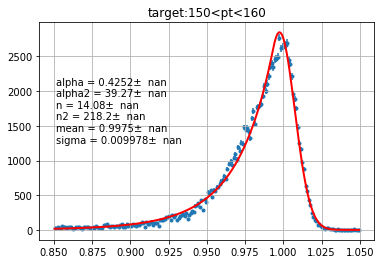

In [24]:
i=15
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1526.89829929 
 TOTAL NCALL = 130 
 NCALLS = 130 
 
 
 EDM = 1.06809658961e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.609565,0.00276303,,,0,100,No
1,alpha2,2.88859,0.100591,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.994525,5.70083e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: SmallIntegralWarning: (10.292032834770021, -3.016220376837352, 0.11467338345205746, 679.7978896521907, 1.05115009461652, 0.2865354696042218)


FCN = 940.030802196 
 TOTAL NCALL = 519 
 NCALLS = 508 
 
 
 EDM = 476.451421152 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.377583,0.00154099,,,0,100,No
1,alpha2,2.49106,0.798596,,,,,No
2,n,106.967,25.755,,,0,1000,No
3,n2,15.1613,177.716,,,0,1000,No
4,mean,0.997396,4.78352e-05,,,0.9,1.1,No
5,sigma,0.0101112,3.4418e-05,,,0,1,No


FCN = 938.647186352 
 TOTAL NCALL = 87 
 NCALLS = 87 
 
 
 EDM = 1.6766932748e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.377583,1,,,0,100,Yes
1,alpha2,2.49106,1,,,,,Yes
2,n,100.573,27.6004,,,0,1000,No
3,n2,9.83271,2.16964,,,0,1000,No
4,mean,0.997396,1,,,0.9,1.1,Yes
5,sigma,0.0100974,3.67497e-05,,,0,1,No


FCN = 934.582214175 
 TOTAL NCALL = 235 
 NCALLS = 235 
 
 
 EDM = 7.66344992759e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.380131,0.00529907,,,0,100,No
1,alpha2,2.98058,0.153897,,,,,No
2,n,105.267,52.1443,,,0,1000,No
3,n2,2.34365,1.09478,,,0,1000,No
4,mean,0.99734,0.000119851,,,0.9,1.1,No
5,sigma,0.0101706,8.14585e-05,,,0,1,No


140<pt<150
16


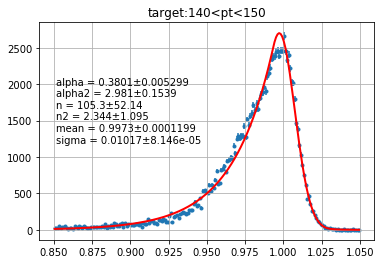

In [25]:
i=16
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1352.94054645 
 TOTAL NCALL = 130 
 NCALLS = 130 
 
 
 EDM = 1.28111836592e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.577086,0.00262288,,,0,100,No
1,alpha2,2.82928,0.0957389,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.994431,5.78219e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1012.11074875 
 TOTAL NCALL = 195 
 NCALLS = 184 
 
 
 EDM = 280.10807913 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.465036,0.010015,,,0,100,No
1,alpha2,2.8259,0.129486,,,,,No
2,n,11.1673,1.11559,,,0,1000,No
3,n2,103.862,904.672,,,0,1000,No
4,mean,0.995803,0.000148169,,,0.9,1.1,No
5,sigma,0.0111744,9.87763e-05,,,0,1,No


FCN = 999.372593388 
 TOTAL NCALL = 77 
 NCALLS = 77 
 
 
 EDM = 3.58218893242e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.465036,1,,,0,100,Yes
1,alpha2,2.8259,1,,,,,Yes
2,n,10.5261,0.334438,,,0,1000,No
3,n2,5.43965,1.28403,,,0,1000,No
4,mean,0.995803,1,,,0.9,1.1,Yes
5,sigma,0.0111277,3.92618e-05,,,0,1,No


FCN = 892.189940226 
 TOTAL NCALL = 438 
 NCALLS = 438 
 
 
 EDM = 3.53817185651e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.380465,0.00561923,,,0,100,No
1,alpha2,3.29493,0.303014,,,,,No
2,n,45.9507,11.8459,,,0,1000,No
3,n2,0.770136,1.04296,,,0,1000,No
4,mean,0.996873,0.000121371,,,0.9,1.1,No
5,sigma,0.0104538,7.94967e-05,,,0,1,No


130<pt<140
17


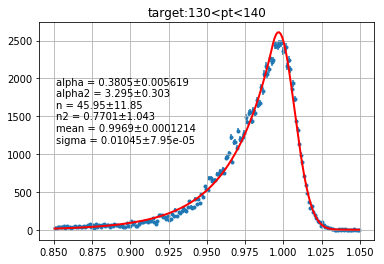

In [26]:
i=17
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1292.45446826 
 TOTAL NCALL = 122 
 NCALLS = 122 
 
 
 EDM = 3.32951463555e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.546063,0.00251328,,,0,100,No
1,alpha2,2.50817,0.0680678,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.994128,6.02469e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 788.177505112 
 TOTAL NCALL = 455 
 NCALLS = 444 
 
 
 EDM = 1912.78232943 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.35344,0.000698158,,,0,100,No
1,alpha2,2.01511,0.253587,,,,,No
2,n,113.934,11.0351,,,0,1000,No
3,n2,70.3295,507.975,,,0,1000,No
4,mean,0.996615,5.89542e-05,,,0.9,1.1,No
5,sigma,0.0103732,6.47232e-05,,,0,1,No


FCN = 787.566068954 
 TOTAL NCALL = 76 
 NCALLS = 65 
 
 
 EDM = 0.45286215452 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.35344,1,,,0,100,Yes
1,alpha2,2.01511,1,,,,,Yes
2,n,113.934,29.4301,,,0,1000,No
3,n2,37.9196,17.0993,,,0,1000,No
4,mean,0.996615,1,,,0.9,1.1,Yes
5,sigma,0.0103732,3.73462e-05,,,0,1,No


FCN = 787.566068954 
 TOTAL NCALL = 93 
 NCALLS = 82 
 
 
 EDM = 3.8587952784 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.35344,0.00473549,,,0,100,No
1,alpha2,2.01511,0.0836779,,,,,No
2,n,113.934,38.086,,,0,1000,No
3,n2,37.9196,35.2039,,,0,1000,No
4,mean,0.996615,0.000129302,,,0.9,1.1,No
5,sigma,0.0103732,0.000103229,,,0,1,No


120<pt<130
18


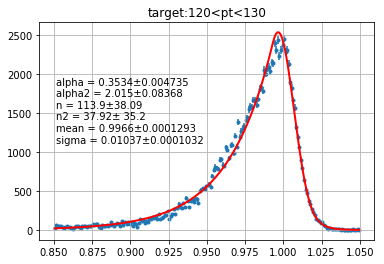

In [27]:
i=18
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1380.55667754 
 TOTAL NCALL = 121 
 NCALLS = 121 
 
 
 EDM = 1.40243478923e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.507475,0.00234744,,,0,100,No
1,alpha2,2.31958,0.051124,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.99373,6.23457e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 726.717409217 
 TOTAL NCALL = 371 
 NCALLS = 360 
 
 
 EDM = 5.76388642038 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.363629,0.00419196,,,0,100,No
1,alpha2,2.43532,0.144271,,,,,No
2,n,98.0152,15.9198,,,0,1000,No
3,n2,6.35103,3.1529,,,0,1000,No
4,mean,0.995239,0.000132681,,,0.9,1.1,No
5,sigma,0.0112197,0.000100304,,,0,1,No


FCN = 726.717409217 
 TOTAL NCALL = 51 
 NCALLS = 40 
 
 
 EDM = 5.05741608882 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.363629,1,,,0,100,Yes
1,alpha2,2.43532,1,,,,,Yes
2,n,98.0152,14.5168,,,0,1000,No
3,n2,6.35103,1.0149,,,0,1000,No
4,mean,0.995239,1,,,0.9,1.1,Yes
5,sigma,0.0112197,3.51015e-05,,,0,1,No


FCN = 726.717409217 
 TOTAL NCALL = 89 
 NCALLS = 78 
 
 
 EDM = 5.77237612472 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.363629,0.00411523,,,0,100,No
1,alpha2,2.43532,0.140718,,,,,No
2,n,98.0152,15.9603,,,0,1000,No
3,n2,6.35103,3.08661,,,0,1000,No
4,mean,0.995239,0.000130153,,,0.9,1.1,No
5,sigma,0.0112197,9.78557e-05,,,0,1,No


110<pt<120
19


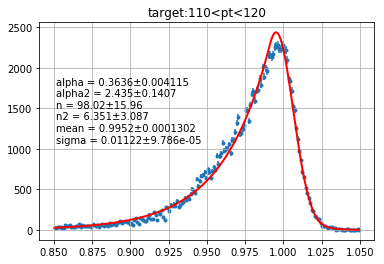

In [28]:
i=19
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1276.4514546 
 TOTAL NCALL = 120 
 NCALLS = 120 
 
 
 EDM = 2.12290568543e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.47871,0.00226381,,,0,100,No
1,alpha2,2.25805,0.0511103,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.993332,6.49774e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 708.809078148 
 TOTAL NCALL = 270 
 NCALLS = 259 
 
 
 EDM = 522188.96024 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.379506,0.00123108,,,0,100,No
1,alpha2,2.90942,0.0848075,,,,,No
2,n,41.1146,1.53044,,,0,1000,No
3,n2,10.8842,637.827,,,0,1000,No
4,mean,0.993895,0.000162204,,,0.9,1.1,No
5,sigma,0.0120107,0.000237583,,,0,1,No


FCN = 671.023844452 
 TOTAL NCALL = 127 
 NCALLS = 116 
 
 
 EDM = 1.72277180778 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.379506,1,,,0,100,Yes
1,alpha2,2.90942,1,,,,,Yes
2,n,114.68,24.8918,,,0,1000,No
3,n2,2.81061,0.573078,,,0,1000,No
4,mean,0.993895,1,,,0.9,1.1,Yes
5,sigma,0.0120824,3.80613e-05,,,0,1,No


FCN = 671.023844452 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 27.1035067215 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.379506,0.00598407,,,0,100,No
1,alpha2,2.90942,0.635425,,,,,No
2,n,114.68,29.1732,,,0,1000,No
3,n2,2.81061,5.46878,,,0,1000,No
4,mean,0.993895,0.000172203,,,0.9,1.1,No
5,sigma,0.0120824,0.000152426,,,0,1,No


100<pt<110
20


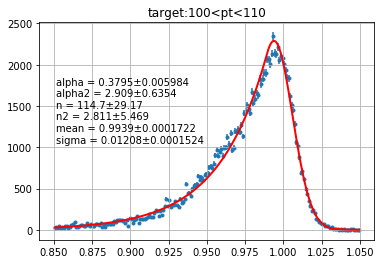

In [29]:
i=20
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1364.28254171 
 TOTAL NCALL = 105 
 NCALLS = 105 
 
 
 EDM = 3.59427491914e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.4485,0.0021638,,,0,100,No
1,alpha2,1.85519,0.0286802,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.992877,7.11105e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 959.322802511 
 TOTAL NCALL = 142 
 NCALLS = 131 
 
 
 EDM = 19.99654271 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.439765,0.00715363,,,0,100,No
1,alpha2,2.1953,0.0479156,,,,,No
2,n,9.2186,0.283854,,,0,1000,No
3,n2,141.617,80.814,,,0,1000,No
4,mean,0.991896,0.000158117,,,0.9,1.1,No
5,sigma,0.0131414,0.000139136,,,0,1,No


FCN = 959.322802511 
 TOTAL NCALL = 53 
 NCALLS = 42 
 
 
 EDM = 62.1336217862 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.439765,1,,,0,100,Yes
1,alpha2,2.1953,1,,,,,Yes
2,n,9.2186,0.246802,,,0,1000,No
3,n2,141.617,154.443,,,0,1000,No
4,mean,0.991896,1,,,0.9,1.1,Yes
5,sigma,0.0131414,4.42642e-05,,,0,1,No


FCN = 959.322802511 
 TOTAL NCALL = 91 
 NCALLS = 80 
 
 
 EDM = 84.4225590475 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.439765,0.00548479,,,0,100,No
1,alpha2,2.1953,0.06526,,,,,No
2,n,9.2186,0.33173,,,0,1000,No
3,n2,141.617,168.303,,,0,1000,No
4,mean,0.991896,0.00014452,,,0.9,1.1,No
5,sigma,0.0131414,0.000111686,,,0,1,No


90<pt<100
21


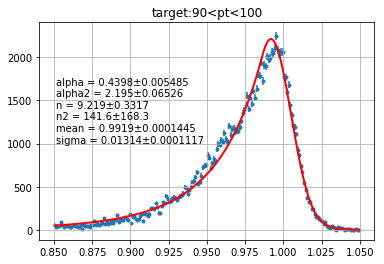

In [30]:
i=21
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.85, 1.05]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1567.75223811 
 TOTAL NCALL = 97 
 NCALLS = 97 
 
 
 EDM = 8.47020412111e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.421736,0.00182559,,,0,100,No
1,alpha2,1.57483,0.0187337,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.992091,7.79758e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1202.65058125 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 300.837311269 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.482827,0.00701658,,,0,100,No
1,alpha2,2.09512,0.0314013,,,,,No
2,n,6.49443,0.129229,,,0,1000,No
3,n2,26.3517,25.9508,,,0,1000,No
4,mean,0.990099,0.000160981,,,0.9,1.1,No
5,sigma,0.0146264,0.000148854,,,0,1,No


FCN = 1120.58130038 
 TOTAL NCALL = 94 
 NCALLS = 83 
 
 
 EDM = 0.693663459354 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.482827,1,,,0,100,Yes
1,alpha2,2.09512,1,,,,,Yes
2,n,8.17153,0.196727,,,0,1000,No
3,n2,147.508,92.9169,,,0,1000,No
4,mean,0.990099,1,,,0.9,1.1,Yes
5,sigma,0.0146605,5.31333e-05,,,0,1,No


FCN = 811.925133809 
 TOTAL NCALL = 328 
 NCALLS = 317 
 
 
 EDM = 0.0538902766807 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.34397,0.00493602,,,0,100,No
1,alpha2,1.82414,0.04225,,,,,No
2,n,103.787,31.6336,,,0,1000,No
3,n2,149.572,63.3191,,,0,1000,No
4,mean,0.992099,0.000149,,,0.9,1.1,No
5,sigma,0.0129592,0.000124073,,,0,1,No


80<pt<90
22


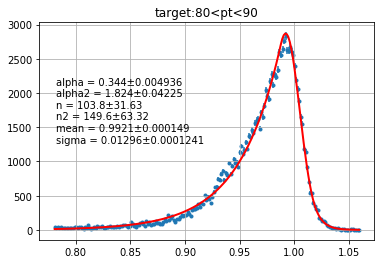

In [31]:
i=22
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.78, 1.06]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1690.02874998 
 TOTAL NCALL = 94 
 NCALLS = 94 
 
 
 EDM = 1.30747103682e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.391451,0.00173889,,,0,100,No
1,alpha2,1.35668,0.0148101,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.991068,9.09068e-05,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1250.79391388 
 TOTAL NCALL = 131 
 NCALLS = 120 
 
 
 EDM = 392.636589623 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.498251,0.00614648,,,0,100,No
1,alpha2,1.99572,0.0246227,,,,,No
2,n,6.17799,0.1271,,,0,1000,No
3,n2,108.823,33.6893,,,0,1000,No
4,mean,0.9883,0.000148009,,,0.9,1.1,No
5,sigma,0.0159642,0.000136955,,,0,1,No


FCN = 1250.79391388 
 TOTAL NCALL = 53 
 NCALLS = 42 
 
 
 EDM = 75.4754634958 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.498251,1,,,0,100,Yes
1,alpha2,1.99572,1,,,,,Yes
2,n,6.17799,0.107466,,,0,1000,No
3,n2,108.823,42.3658,,,0,1000,No
4,mean,0.9883,1,,,0.9,1.1,Yes
5,sigma,0.0159642,5.60722e-05,,,0,1,No


FCN = 756.988491312 
 TOTAL NCALL = 175 
 NCALLS = 164 
 
 
 EDM = 22.202729795 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.381783,0.00558668,,,0,100,No
1,alpha2,1.97531,0.0299532,,,,,No
2,n,25.1983,1.85864,,,0,1000,No
3,n2,39.1176,28.994,,,0,1000,No
4,mean,0.989693,0.000161602,,,0.9,1.1,No
5,sigma,0.0143968,0.000119192,,,0,1,No


70<pt<80
23


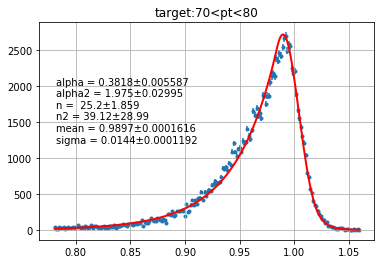

In [32]:
i=23
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.78, 1.06]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1772.47435395 
 TOTAL NCALL = 93 
 NCALLS = 93 
 
 
 EDM = 7.80155526195e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.349519,0.00161094,,,0,100,No
1,alpha2,1.1458,0.0111112,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.989598,0.000106571,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1460.3203473 
 TOTAL NCALL = 127 
 NCALLS = 116 
 
 
 EDM = 290.035616185 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.458066,0.006106,,,0,100,No
1,alpha2,1.59463,0.0199709,,,,,No
2,n,5.06763,0.102812,,,0,1000,No
3,n2,53.6646,21.4882,,,0,1000,No
4,mean,0.98741,0.000153762,,,0.9,1.1,No
5,sigma,0.0157755,0.000175143,,,0,1,No


FCN = 1316.71740254 
 TOTAL NCALL = 73 
 NCALLS = 62 
 
 
 EDM = 5.39553820149 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.458066,1,,,0,100,Yes
1,alpha2,1.59463,1,,,,,Yes
2,n,6.82125,0.158451,,,0,1000,No
3,n2,138.865,37.1028,,,0,1000,No
4,mean,0.98741,1,,,0.9,1.1,Yes
5,sigma,0.0161153,6.37011e-05,,,0,1,No


FCN = 666.202594448 
 TOTAL NCALL = 341 
 NCALLS = 330 
 
 
 EDM = 1.56087790248 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.377855,0.00373577,,,0,100,No
1,alpha2,2.4053,0.0742258,,,,,No
2,n,114.872,17.6699,,,0,1000,No
3,n2,2.61705,0.578829,,,0,1000,No
4,mean,0.987023,0.000167241,,,0.9,1.1,No
5,sigma,0.0164178,0.000130525,,,0,1,No


60<pt<70
24


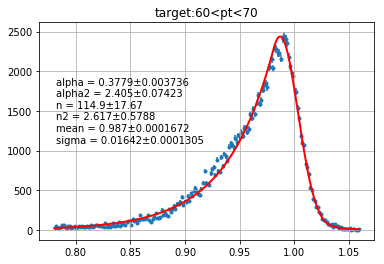

In [33]:
i=24
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.78, 1.06]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 1996.9551785 
 TOTAL NCALL = 95 
 NCALLS = 95 
 
 
 EDM = 8.69160099231e-08 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.322106,0.00157141,,,0,100,No
1,alpha2,0.967254,0.00900431,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.987321,0.000130029,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1778.74089888 
 TOTAL NCALL = 111 
 NCALLS = 100 
 
 
 EDM = 1407.79286991 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.375943,12.1261,,,0,100,No
1,alpha2,1.17109,0.707107,,,,,No
2,n,5.12696,120.931,,,0,1000,No
3,n2,84.8042,183.373,,,0,1000,No
4,mean,0.986375,0.0648876,,,0.9,1.1,No
5,sigma,0.0141385,0.11871,,,0,1,No


FCN = 1602.5911975 
 TOTAL NCALL = 74 
 NCALLS = 63 
 
 
 EDM = 130.317784063 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.375943,1,,,0,100,Yes
1,alpha2,1.17109,1,,,,,Yes
2,n,6.40329,0.139833,,,0,1000,No
3,n2,137.342,34.0827,,,0,1000,No
4,mean,0.986375,1,,,0.9,1.1,Yes
5,sigma,0.0142175,6.02198e-05,,,0,1,No


FCN = 1121.65314056 
 TOTAL NCALL = 111 
 NCALLS = 100 
 
 
 EDM = 1285.08605301 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.455653,0.013239,,,0,100,No
1,alpha2,1.58613,0.0268162,,,,,No
2,n,9.57007,0.423504,,,0,1000,No
3,n2,125.679,33.5765,,,0,1000,No
4,mean,0.983477,0.000308681,,,0.9,1.1,No
5,sigma,0.0187284,0.000326984,,,0,1,No


50<pt<60
25


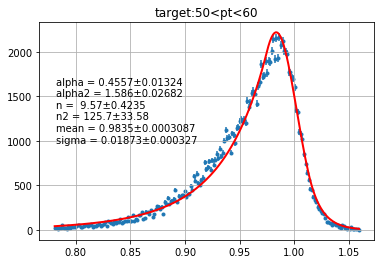

In [34]:
i=25
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.78, 1.06]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

FCN = 2124.58998336 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 1.34282390248e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.284263,0.00129496,,,0,100,No
1,alpha2,0.781474,0.00681996,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.983921,0.000152639,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1699.86456393 
 TOTAL NCALL = 118 
 NCALLS = 107 
 
 
 EDM = 364.683033084 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.3989,0.010678,,,0,100,No
1,alpha2,1.15696,0.0260354,,,,,No
2,n,5.9578,0.110901,,,0,1000,No
3,n2,98.4501,24.6207,,,0,1000,No
4,mean,0.982073,0.000256815,,,0.9,1.1,No
5,sigma,0.0177407,0.000440485,,,0,1,No


FCN = 1699.86456393 
 TOTAL NCALL = 53 
 NCALLS = 42 
 
 
 EDM = 101.089679788 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.3989,1,,,0,100,Yes
1,alpha2,1.15696,1,,,,,Yes
2,n,5.9578,0.102464,,,0,1000,No
3,n2,98.4501,16.8534,,,0,1000,No
4,mean,0.982073,1,,,0.9,1.1,Yes
5,sigma,0.0177407,7.51495e-05,,,0,1,No


FCN = 712.722111207 
 TOTAL NCALL = 362 
 NCALLS = 351 
 
 
 EDM = 1.54023759274 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.381127,0.00469086,,,0,100,No
1,alpha2,1.75003,0.025596,,,,,No
2,n,107.526,14.0496,,,0,1000,No
3,n2,12.3043,1.69728,,,0,1000,No
4,mean,0.97984,0.000229412,,,0.9,1.1,No
5,sigma,0.0207344,0.000206846,,,0,1,No


40<pt<50
26


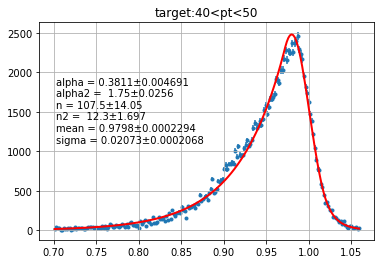

In [35]:
i=26
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.7, 1.06]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.002, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 1843.40346357 
 TOTAL NCALL = 86 
 NCALLS = 86 
 
 
 EDM = 2.76573582307e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.236085,0.00115366,,,0,100,No
1,alpha2,0.62903,0.00472369,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.979871,0.000186626,,,0.9,1.1,No
5,sigma,0.012,1,,,0,1,Yes


FCN = 1432.04014236 
 TOTAL NCALL = 117 
 NCALLS = 106 
 
 
 EDM = 419.018583925 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.326343,0.00924613,,,0,100,No
1,alpha2,0.948842,0.0212711,,,,,No
2,n,7.30047,0.160474,,,0,1000,No
3,n2,131.289,23.8893,,,0,1000,No
4,mean,0.978861,0.000256168,,,0.9,1.1,No
5,sigma,0.0183855,0.000473737,,,0,1,No


FCN = 1432.04014236 
 TOTAL NCALL = 53 
 NCALLS = 42 
 
 
 EDM = 83.9075957813 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.326343,1,,,0,100,Yes
1,alpha2,0.948842,1,,,,,Yes
2,n,7.30047,0.164507,,,0,1000,No
3,n2,131.289,20.2212,,,0,1000,No
4,mean,0.978861,1,,,0.9,1.1,Yes
5,sigma,0.0183855,7.83989e-05,,,0,1,No


FCN = 1432.04014236 
 TOTAL NCALL = 89 
 NCALLS = 78 
 
 
 EDM = 348.476106541 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.326343,0.00735269,,,0,100,No
1,alpha2,0.948842,0.0176523,,,,,No
2,n,7.30047,0.230797,,,0,1000,No
3,n2,131.289,20.4899,,,0,1000,No
4,mean,0.978861,0.000296456,,,0.9,1.1,No
5,sigma,0.0183855,0.000349656,,,0,1,No


30<pt<40
27


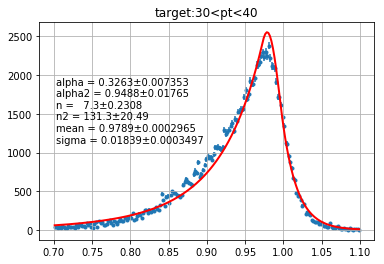

In [36]:
i=27
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.7, 1.1]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.012,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:65: LogWarning: x is really small return 0


FCN = 2586.24266112 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 5.53708194586e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.27299,0.0012132,,,0,100,No
1,alpha2,0.595569,0.00389192,,,,,No
2,n,5,1,,,0,1000,Yes
3,n2,110,1,,,0,1000,Yes
4,mean,0.967464,0.00023476,,,0.9,1.1,No
5,sigma,0.016,1,,,0,1,Yes


FCN = 1849.98395083 
 TOTAL NCALL = 115 
 NCALLS = 104 
 
 
 EDM = 373.097289529 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.369169,0.0117376,,,0,100,No
1,alpha2,0.906034,0.0212351,,,,,No
2,n,7.79335,0.13457,,,0,1000,No
3,n2,72.4318,25.4765,,,0,1000,No
4,mean,0.966547,0.000347565,,,0.9,1.1,No
5,sigma,0.0247923,0.000704662,,,0,1,No


FCN = 1674.80795315 
 TOTAL NCALL = 82 
 NCALLS = 71 
 
 
 EDM = 43.1076039373 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.369169,1,,,0,100,Yes
1,alpha2,0.906034,1,,,,,Yes
2,n,9.84789,0.264685,,,0,1000,No
3,n2,118.984,19.8175,,,0,1000,No
4,mean,0.966547,1,,,0.9,1.1,Yes
5,sigma,0.0243938,0.000102136,,,0,1,No


FCN = 912.476385116 
 TOTAL NCALL = 189 
 NCALLS = 178 
 
 
 EDM = 48.4521344722 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 True 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,alpha,0.441701,11.9701,,,0,100,No
1,alpha2,1.41353,0.709876,,,,,No
2,n,34.8076,119.455,,,0,1000,No
3,n2,27.0161,113.401,,,0,1000,No
4,mean,0.960139,0.0597701,,,0.9,1.1,No
5,sigma,0.0334885,0.117249,,,0,1,No


20<pt<30
28


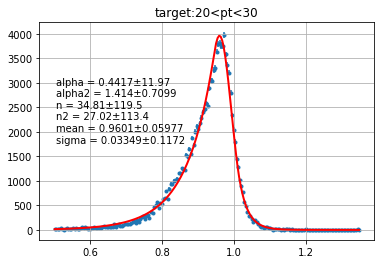

In [37]:
i=28
df=data.query(feat_pt[i]).astype('double')
df=df['target']
bound_DCB=[0.5, 1.35]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, df, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
        #first step
   
    if j==0: 
            pars_dcb = dict(mean  = 1.001, 
                        fix_mean = False,
                        sigma  = 0.016,
                        fix_sigma =True,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 5,
                        fix_n  = True,
                        alpha2 =0.8,
                        fix_alpha2 = False,
                        n2     = 110,
                        fix_n2  = True
        
                           ) 
            
    elif j==2:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = True,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = True,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       
    
            
        #optimize parameter withoptimized start parameter
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
       
       

    minuit = iminuit.Minuit(binned_likelihood,print_level=3,limit_alpha=(0,100),limit_sigma=(0,1),limit_n=(0,1000),limit_n2=(0,1000),limit_mean=(0.9,1.1), **pars_dcb)
        
    minuit.migrad() #optimized parameter
       
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.05,0.75))
    
mean_pt_un[i]=minuit.values['mean']
mean_err_pt_un[i]=minuit.errors['mean']
sigma_pt_un[i]=minuit.values['sigma']
sigma_err_pt_un[i]=minuit.errors['sigma']
print(feat_pt[i])
print(i)     
plt.title('target:'+feat_pt[i])
plt.savefig(os.path.join(out_dir+'plot','target:'+feat_pt[i]+'_fit'+'.png'))
plt.show()
np.savetxt('pt_parameter_Uncorrected.csv', (mean_pt_un,sigma_pt_un), delimiter=',')